In [1]:
%%time
# What version of Python do you have?
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skimage import io, color, transform, feature, data, exposure, filters
from skimage.feature import hog
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split


import matplotlib
matplotlib.use("Agg")

import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
import itertools
import shutil
import random
import glob
from imutils import paths
import argparse
import cv2
import os


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

%matplotlib inline

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas 1.1.3
Scikit-Learn 0.23.2
GPU is NOT AVAILABLE
Wall time: 8.76 s


### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [ ]:
help(BinaryClassificationPerformance)

### file paths and names

In [2]:
ci_path = '/Users/Charles/Desktop/ML/A2/plane_data/cropped_images/' # file path for cropped images for training
l_file = '/Users/Charles/Desktop/ML/A2/plane_data/plane_labels.csv' # file path and file name for csv with labels

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [2]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which is 8,400 pixels
dims = (60, 140) # 50% of the original size, 2100 pixels

downscaled image shape: 
(60, 140)
image representation (first row of pixels): 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


example of transformation: 


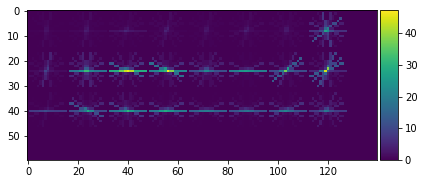

In [4]:
# def image_manipulation_canny(imname, imgs_path, imview=False):
#     warnings.filterwarnings('ignore')
#     imname = imgs_path + imname + '.png'
#     img_raw = io.imread(imname, as_gray=True)
#     downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
#     final_image = feature.canny(downscaled) # edge filter image with Canny algorithm
#     if imview==True:
#         io.imshow(final_image)
#     warnings.filterwarnings('always')
#     return final_image_canny

def image_manipulation_hog(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png' # define file path
#     img_raw = io.imread(imname, as_gray=True) # reads the image from file path
    img_raw = io.imread(imname) # reads the image from file path
    # what are the ramifications of 'multichannel=True' processing color image?  
    # (c) The last image dimension where rbga, a is last dimension.  Then, do these images have a?
    # blocks are many cells and cells are many pixels.  
    # (c) Blocks may overlap and cells are rep more than once in final distribution.
    # is there a way to do a C-Hog with sklearn?
    fd, final_image_hog = hog(img_raw, orientations=9, pixels_per_cell=(16, 16), 
                          cells_per_block=(4, 4), visualize=True, multichannel=True)
    final_image = np.array([final_image_hog])
    if imview==True:
        io.imshow(final_image_hog)
    warnings.filterwarnings('always')
    return final_image_hog


# test the function, look at input/output
test_image = image_manipulation_hog('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

for comparison, look at original image:

In [ ]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

# tensorflow

In [52]:
%%time
# the original dimensions of cropped images: (60, 140), which is 8,400 pixels
# USAGE
# python train.py --dataset 101_ObjectCategories

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class StridedNet(object):
#     @staticmethod
    def build(width, height, depth, classes, reg, init="he_normal"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # our first CONV layer will learn a total of 16 filters, each
        # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
        # the spatial dimensions of the volume
        model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid",
            kernel_initializer=init, kernel_regularizer=reg,
            input_shape=inputShape))

        # here we stack two CONV layers on top of each other where
        # each layer will learn a total of 32 (3x3) filters
        model.add(Conv2D(32, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # stack two more CONV layers, keeping the size of each filter
        # as 3x3 but increasing to 64 total learned filters
        model.add(Conv2D(64, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # increase the number of filters again, this time to 128
        model.add(Conv2D(128, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # fully-connected layer
        model.add(Flatten())
        model.add(Dense(512, kernel_initializer=init))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
#     help="path to input dataset")
# ap.add_argument("-e", "--epochs", type=int, default=50,
#     help="# of epochs to train our network for")
# ap.add_argument("-p", "--plot", type=str, default="plot1.png",
#     help="C:/Users/Charles/Downloads/keras-conv2d-example")
# args = vars(ap.parse_args())
# argparse gave (input filepath?, # of epochs, plot result)
    
# A alternative for argument parser; directly feed file paths into function
# def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
# def process_raw_data(labels_fn=l_file, images_fp=ci_path, my_random_seed, imview=False, test=False):
plane_data = pd.read_csv(l_file) # read in photograph labels

features_list = []
image_list = []

# for index, row in plane_data.iterrows():
# #         features_list.append(image_manipulation_hog(row['img_name'], images_fp))
# # grab the list of images in our dataset directory, then initialize
# # the list of data (i.e., images) and class images
# #     print("[INFO] loading images...")
# # C
#     fullimpath = ci_path + row['img_name'] + '.png'
#     image_list.append(fullimpath)
# imagePaths = image_list

data = []
# in orig, labels is y_list
labels = []

# initialize the set of labels from the CALTECH-101 dataset we are
# going to train our network on
# LABELS = set(["TRUE"])


# loop over the image paths
#     for imagePath in imagePaths:
for index, row in plane_data.iterrows():
    # extract the class label from the filename
#         label = imagePath.split(os.path.sep)[-2]
#         # extract the class label from csv column
#     label = row['img_name']
    label = row['plane']
    
    # if the label of the current image is not part of of the labels
    # are interested in, then ignore the image
#         if label not in LABELS:
#     if row['plane'] = 'False': #invalid syntax
    if label == "TRUE":
        continue

    # load the image and resize it to be a fixed 96x96 pixels,
    # ignoring aspect ratio
    # for our data set, no need to resize
    # cv2 or Opencv analyzes images
    # does same function as HOG (?)
    fullimpath = ci_path + row['img_name'] + '.png'

    
    image = cv2.imread(fullimpath)
#         image = cv2.resize(image, (96, 96))

    # update the data and labels lists, respectively
    # D
    data.append(image)
    labels.append(label)

    
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
# what does 255.0 refer to?
# E
data = np.array(data, dtype="float") / 255.0

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels.shape)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
# F
data_train, data_test, y_train, y_test = train_test_split(data, labels,
    test_size=0.25, stratify=labels, random_state=42)   

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
# opt = Adam(lr=1e-4, decay=1e-4 / args["epochs"])
# w/o args, just use 50 for "epochs"
opt = Adam(lr=1e-4, decay=1e-4 / 50)
sn = StridedNet()
model = sn(width=70, height=30, depth=3,
    classes=len(lb.classes_), reg=l2(0.0005))
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6758, 1)
[INFO] compiling model...


TypeError: 'StridedNet' object is not callable

In [ ]:
%%time
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=72, imview=False, test=False)

In [ ]:
# train the network
print("[INFO] training network for {} epochs...".format(
    args["epochs"]))
# what is batch_size=32?
H = model.fit(x=aug.flow(data_train, y_train, batch_size=32),
    validation_data=(data_test, y_test), steps_per_epoch=len(trainX) // 32,
    epochs=args["epochs"])

In [50]:
%%time

# TF Convolutional Neural Network
# from: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class StridedNet:
    @staticmethod
    def build(width, height, depth, classes, reg, init="he_normal"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # our first CONV layer will learn a total of 16 filters, each
        # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
        # the spatial dimensions of the volume
        model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid",
            kernel_initializer=init, kernel_regularizer=reg,
            input_shape=inputShape))

        # here we stack two CONV layers on top of each other where
        # each layer will learn a total of 32 (3x3) filters
        model.add(Conv2D(32, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # stack two more CONV layers, keeping the size of each filter
        # as 3x3 but increasing to 64 total learned filters
        model.add(Conv2D(64, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # increase the number of filters again, this time to 128
        model.add(Conv2D(128, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # fully-connected layer
        model.add(Flatten())
        model.add(Dense(512, kernel_initializer=init))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

sn = StridedNet()
sn.fit(data_train, y_train)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'StridedNet' object has no attribute 'fit'

In [50]:
%%time

# TF Convolutional Neural Network
# from: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class StridedNet:
    @staticmethod
    def build(width, height, depth, classes, reg, init="he_normal"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # our first CONV layer will learn a total of 16 filters, each
        # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
        # the spatial dimensions of the volume
        model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid",
            kernel_initializer=init, kernel_regularizer=reg,
            input_shape=inputShape))

        # here we stack two CONV layers on top of each other where
        # each layer will learn a total of 32 (3x3) filters
        model.add(Conv2D(32, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # stack two more CONV layers, keeping the size of each filter
        # as 3x3 but increasing to 64 total learned filters
        model.add(Conv2D(64, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # increase the number of filters again, this time to 128
        model.add(Conv2D(128, (3, 3), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
            kernel_initializer=init, kernel_regularizer=reg))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Dropout(0.25))

        # fully-connected layer
        model.add(Flatten())
        model.add(Dense(512, kernel_initializer=init))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

sn = StridedNet()
sn.fit(data_train, y_train)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'StridedNet' object has no attribute 'fit'

In [ ]:
# plot the training loss and accuracy
N = args["epochs"]
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

# tf 2.0

In [2]:
cc_path = '/Users/Charles/Desktop/ML/A2/dump_folder/cropped_images/' # file path for cropped images for training
ll_file = '/Users/Charles/Desktop/ML/A2/dump_folder/plane_labels.csv' # file path and file name for csv with labels

os.chdir(cc_path)
# if folders don't exist, make folders
if os.path.isdir('train/TRUE') is False:
    print('NO')
    
    
    

In [3]:
# https://www.youtube.com/watch?v=qFJeN9V1ZsI
cc_path = '/Users/Charles/Desktop/ML/A2/dump_folder/cropped_images/' # file path for cropped images for training
ll_file = '/Users/Charles/Desktop/ML/A2/dump_folder/plane_labels.csv' # file path and file name for csv with labels

os.chdir(cc_path)
# if folders don't exist, make folders
if os.path.isdir('train/TRUE') is False:
    os.makedirs('train/TRUE')
    os.makedirs('train/FALSE')
    os.makedirs('valid/TRUE')
    os.makedirs('valid/FALSE')
    os.makedirs('test/TRUE')
    os.makedirs('test/FALSE')

# elif os.path.isdir('train/TRUE') is True:
    
#     plane_data = pd.read_csv(ll_file) # read in photograph labels

#     features_list = []
#     image_list = []
#     data = []
#     labels = []
    
#     LABELS = set([True]) # True/False in the csv is read as Boolean and not string

#     for index, row in plane_data.iterrows():
        
#         label = row['plane']
#         fullimpath = cc_path + row['img_name'] + '.png'
        
#         if label not in LABELS:
# #         if label == "TRUE":

#             newimpath = cc_path + 'FALSE.' + row['img_name'] + '.png'
#             os.rename(fullimpath, newimpath)

#         else:
# #         elif label == "FALSE":
#             newimpath = cc_path + 'TRUE.' + row['img_name'] + '.png'
#             os.rename(fullimpath, newimpath)

#     counter = len(glob.glob('FALSE*'))
#     print(counter)

#     for c in random.sample(glob.glob('TRUE*'), 66):
#         shutil.move(c, 'train/TRUE')
#     for c in random.sample(glob.glob('FALSE*'), 4327):
#         shutil.move(c, 'train/FALSE')
#     for c in random.sample(glob.glob('TRUE*'), 25):
#         shutil.move(c, 'valid/TRUE')
#     for c in random.sample(glob.glob('FALSE*'), 1664):
#         shutil.move(c, 'valid/FALSE')
#     for c in random.sample(glob.glob('TRUE*'), 10):
#         shutil.move(c, 'test/TRUE')
#     for c in random.sample(glob.glob('FALSE*'), 666):
#         shutil.move(c, 'test/FALSE')

#change directory, for what?
os.chdir('../../')

In [4]:
%%time
train_path = 'dump_folder/cropped_images/train'
valid_path = 'dump_folder/cropped_images/valid'
test_path = 'dump_folder/test'

Wall time: 0 ns


In [7]:
%%time
# https://www.youtube.com/watch?v=qFJeN9V1ZsI

# pre-processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(60, 140), classes=['FALSE', 'TRUE'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(60, 140), classes=['FALSE', 'TRUE'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(60, 140), classes=['FALSE', 'TRUE'], batch_size=10, shuffle=False)

Found 6758 images belonging to 2 classes.
Found 914 images belonging to 2 classes.
Found 1523 images belonging to 2 classes.
Wall time: 1.02 s


In [102]:
# confirming the sizes of ea batch(?) and no. of classes in ea batch
# assert train_batches.n == 4393
# assert valid_batches.n == 1689
# assert test_batches.n == 676
# assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [8]:
# grab a batch from training, processing every ten images and corresponding labels
imgs, labels = next(train_batches)

In [9]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

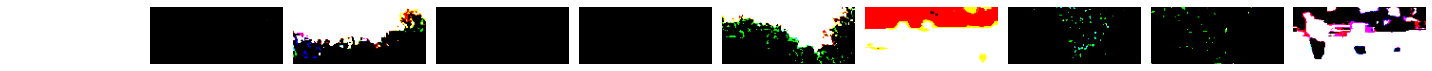

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Wall time: 548 ms


In [10]:
%%time
plotImages(imgs)
print(labels)

In [11]:
%%time
# this is the CNN model
# training and validation
num_classes = 2

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(60, 140, 3)), # 3 is no. color channels
    MaxPool2D(pool_size=(2, 2), strides=2), # what does maxpool do?
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
#     Dense(units=2, activation='softmax'), # 2 units refers to classes or labels, in this case, T/F
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='sigmoid')
])

model.summary()

# def tp_rate(y_true, y_pred):
#     tp = tf.keras.metrics.Recall()
#     return tp
    

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# instead of adam, could use a sigmoid with binary crossentropy

model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 140, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 70, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 35, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 17, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15232)             0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

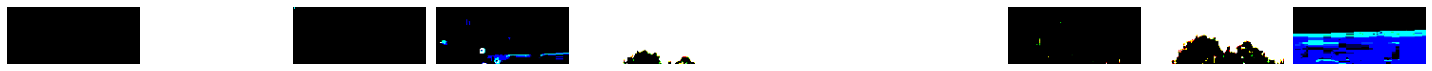

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [12]:
# test set
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [13]:
# test_batches.classes

predictions = model.predict(x=test_batches, verbose=0)
predictions = np.round(predictions)
print(predictions)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [24]:
# print submission

ci_path = '/Users/Charles/Desktop/ML/A2/plane_data/cropped_images/' # file path for cropped images for training
l_file = '/Users/Charles/Desktop/ML/A2/test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

plane_data = pd.read_csv(l_file)
# print(plane_data['img_name'])

df = pd.DataFrame(data=predictions, columns=["False", "prediction"])
df["prediction"] = df["prediction"].replace({0: "False", 1: "True"})
# print(df["prediction"])

final = pd.concat([plane_data['img_name'], df["prediction"]], axis=1)

print(final)
final.to_csv('airplane_submission_final.csv', index=False)

                      img_name prediction
0     2016-08-02T13+50+24_430Z      False
1     2016-08-02T14+12+37_390Z      False
2     2016-08-03T12+32+21_790Z      False
3     2016-08-03T13+19+28_320Z      False
4     2016-08-05T15+24+58_670Z      False
...                        ...        ...
1518  2018-03-10T15+26+19_760Z      False
1519  2018-03-10T15+48+42_550Z      False
1520  2018-03-13T12+22+18_290Z      False
1521  2018-03-13T12+57+53_900Z      False
1522  2018-03-13T13+00+55_600Z      False

[1523 rows x 2 columns]


In [18]:
y_pred=np.argmax(predictions, axis=1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [19]:
%%time
# what's the function of a confusion matrix?
# related to the reason for 'Shuffle=false' previously
print(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [21]:
test_batches.class_indices

{'FALSE': 0, 'TRUE': 1}

Confusion matrix, without normalization
[[666   0]
 [  1  11]]


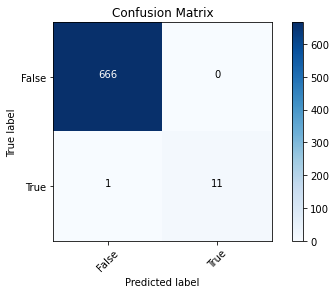

In [22]:
cm_plot_labels = ['False', 'True']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
# trying to compute performance metrics for this run,
# (c) have to figure out how to match image id (in csv) with binary classification (one column in 'predictions1' array)
# (c) and convert to dataframe.  Need dataframe to get '.compute_measures' and '.performance_measures'
# (c) Then can perform below steps.
# See how to feed the test images into this model.

y_pred=np.argmax(predictions, axis=1)
y_true=test_batches.classes
tf_performance = BinaryClassificationPerformance(y_pred, y_true, 'tf1')
tf_performance.compute_measures()
tf_performance.performance_measures['set'] = 'train'
print('Performance: ')
print(tf_performance.performance_measures)
# print(predictions1)
# mm = pd.DataFrame(predictions1)

# mm.compute_measures()

# nn_performance_test.compute_measures()
# nn_performance_test.performance_measures['set'] = 'test'

# list of fits to compare: 
final_fits1 = []

final_fits1.append(tf_performance.performance_measures)
# final_fits1.append(nn_performance_test.performance_measures)

Performance: 
{'Pos': 12, 'Neg': 666, 'TP': 11, 'TN': 666, 'FP': 0, 'FN': 1, 'Accuracy': 0.9985250737463127, 'Precision': 1.0, 'Recall': 0.9166666666666666, 'desc': 'tf1', 'set': 'train'}


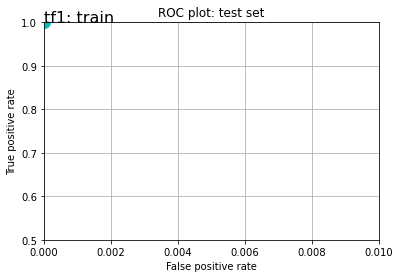

In [18]:
# plt.figure(figsize=(10,10))

for fit in final_fits1:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 0.01, 0.5, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.grid(b=True)
plt.show()


In [24]:
# test set
t1_dir = 'dump_folder/test'

t1_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
t1_set = t1_batches.flow_from_directory(t1_dir, target_size=(60, 140), batch_size=10, class_mode='binary', shuffle=True)

Found 1523 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

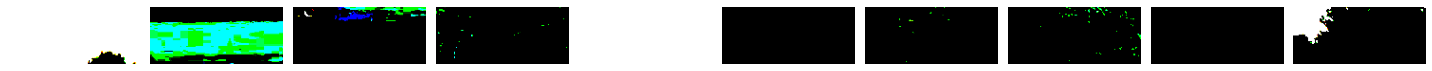

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [23]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
predictions1 = model.predict(x=t1_batches, verbose=0)
predictions1 = np.round(predictions1)
print(predictions1)

# tf 3.0

In [57]:
%%time

# code from https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

train_dir = '/Users/Charles/Desktop/ML/A2/dump_folder/train'
test_dir = '/Users/Charles/Desktop/ML/A2/dump_folder/cropped_images/train/TRUE'

# what does '.format(i)...' do?
train_False = ['/Users/Charles/Desktop/ML/A2/dump_folder/train/{}'.format(i) for i in os.listdir(train_dir) if 'FALSE' in i] # get False imgs
train_True = ['/Users/Charles/Desktop/ML/A2/dump_folder/train/{}'.format(i) for i in os.listdir(train_dir) if 'TRUE' in i] # get True imgs

test_imgs = ['/Users/Charles/Desktop/ML/A2/dump_folder/cropped_images/train/TRUE/{}'.format(i) for i in os.listdir(test_dir)] # get test imgs

train_imgs = train_False[:5658] + train_True[:91]
random.shuffle(train_imgs)
print(len(test_imgs))

2
Wall time: 51 ms


In [40]:
%%time

# Declare image dimensions
# using coloured images

nrows = 140
ncolumns = 60
channels = 3

def read_process_image(list_of_images):
    """
    Returns two arrays:
        X is an array of resized images
        y is an array of labels
    """
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC)) #read img
        
        # get the labels, need an equation here to either get from csv or from filename
        if 'FALSE' in image:
            y.append(1)
        elif 'TRUE'in image:
            y.append(0)
            
    return X, y

X, y = read_process_image(train_imgs)

Wall time: 3.4 s


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


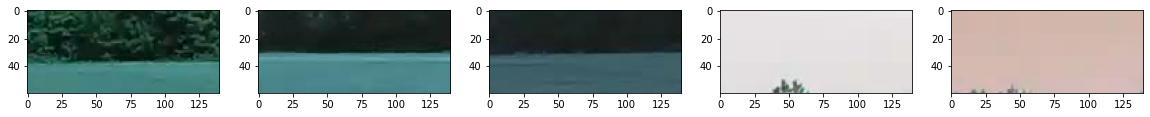

In [41]:
plt.figure(figsize=(20, 10))
columns = 5
for i in range (columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

In [42]:
# Convert list to numpy array
X = np.array(X)
y = np.array(y)

print("Shape of train images is: ", X.shape)
print("Shape of labels is: ", y.shape)

Shape of train images is:  (5749, 60, 140, 3)
Shape of labels is:  (5749,)


In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=36)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_valid.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_valid.shape)

ntrain = len(X_train)
nvalid = len(X_valid)

batch_size = 32

Shape of train images is: (4599, 60, 140, 3)
Shape of validation images is: (1150, 60, 140, 3)
Shape of labels is: (4599,)
Shape of labels is: (1150,)


In [44]:
%%time

from keras import layers
from keras import models
from keras import optimizers

model1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(60, 140, 3)), # 3 is no. color channels
    MaxPool2D(pool_size=(2, 2)), # what does maxpool do?
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
#     Dense(units=2, activation='softmax'), # 2 units refers to classes or labels, in this case, T/F
    Dense(units=512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Wall time: 538 ms


In [45]:
%%time
model1.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

Wall time: 50 ms


In [46]:
%%time

# in this case, ImageDataGenerator is not used for preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size)

Wall time: 234 ms


In [48]:
%%time
history = model1.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=10,
                              validation_data=valid_generator,
                              validation_steps=nvalid // batch_size,
                              verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 143 steps, validate for 35 steps
Epoch 1/10
143/143 - 84s - loss: 0.1187 - acc: 0.9831 - val_loss: 0.0633 - val_acc: 0.9893
Epoch 2/10
143/143 - 104s - loss: 0.0814 - acc: 0.9834 - val_loss: 0.0273 - val_acc: 0.9893
Epoch 3/10
143/143 - 111s - loss: 0.0576 - acc: 0.9836 - val_loss: 0.0178 - val_acc: 0.9955
Epoch 4/10
143/143 - 105s - loss: 0.0470 - acc: 0.9860 - val_loss: 0.0173 - val_acc: 0.9955
Epoch 5/10
143/143 - 107s - loss: 0.0420 - acc: 0.9869 - val_loss: 0.0195 - val_acc: 0.9920
Epoch 6/10
143/143 - 106s - loss: 0.0404 - acc: 0.9873 - val_loss: 0.0357 - val_acc: 0.9821
Epoch 7/10
143/143 - 105s - loss: 0.0307 - acc: 0.9906 - val_loss: 0.0124 - val_acc: 0.9946
Epoch 8/10
143/143 - 106s - loss: 0.0318 - acc: 0.9897 - val_loss: 0.0131 - val_acc: 0.9955
Epoch 9/10
143/143 - 109s - loss: 0.0335 - acc: 0.9901 - val_loss: 0.0294 - val_acc: 0.9857
Epoch 10/10
143/143 - 109s - loss: 0.0288 - acc: 0.9899 - val_loss: 0.0109 - val

In [58]:
%%time

# pass a test set without labels
X_test, y_test = read_process_image(test_imgs[0:10])
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

Wall time: 2.01 ms


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


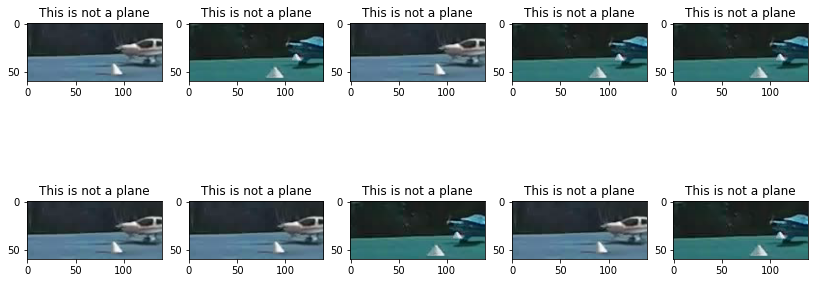

Wall time: 1.21 s


In [59]:
%%time

i = 0
text_labels = []
plt.figure(figsize=(14,6))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model1.predict(batch)
    if pred>0.5:
        text_labels.append('not a plane')
    else:
        text_labels.append('a plane')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

# fails completely against half plane imgs in training set

In [ ]:
    plane_data = pd.read_csv(ll_file) # read in photograph labels

    features_list = []
    image_list = []
    data = []
    labels = []
    
    LABELS = set([True]) # True/False in the csv is read as Boolean and not string

    for index, row in plane_data.iterrows():
        
        label = row['plane']
        fullimpath = cc_path + row['img_name'] + '.png'
        
        if label not in LABELS:
#         if label == "TRUE":

            newimpath = cc_path + 'FALSE.' + row['img_name'] + '.png'
            os.rename(fullimpath, newimpath)

        else:
#         elif label == "FALSE":
            newimpath = cc_path + 'TRUE.' + row['img_name'] + '.png'
            os.rename(fullimpath, newimpath)

# VGG16

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

# function to process raw images, resulting in training and test datasets

In [57]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation_hog(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
%%time
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=72, imview=False, test=False)

# train Perceptron

In [8]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', max_iter=3000)
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)
print('Accuracy')
print(prc_performance_test.performance_measures['Accuracy']*100)
print('Precision')
print(prc_performance_test.performance_measures['Precision']*100)
print('True Positive')
print(prc_performance_test.performance_measures['Recall']*100)
print('False Positive')
print(prc_performance_test.performance_measures['FP']/prc_performance_test.performance_measures['Neg']*100)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expecte

TRAINING SET: 
{'Pos': 70, 'Neg': 4998, 'TP': 70, 'TN': 4998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 31, 'Neg': 1659, 'TP': 29, 'TN': 1658, 'FP': 1, 'FN': 2, 'Accuracy': 0.9982248520710059, 'Precision': 0.9666666666666667, 'Recall': 0.9354838709677419, 'desc': 'prc', 'set': 'test'}
Accuracy
99.82248520710058
Precision
96.66666666666667
True Positive
93.54838709677419
False Positive
0.06027727546714888


In [ ]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

In [ ]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

In [ ]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

In [ ]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [9]:
%%time
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(400, 400, 400, 400), max_iter=2000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn_1234')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test_1234')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)
print('True Positive')
print(nn_performance_test.performance_measures['TP']/nn_performance_test.performance_measures['Pos']*100)
print('False Positive')
print(nn_performance_test.performance_measures['FP']/nn_performance_test.performance_measures['Neg']*100)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

# turn off warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MLPClassifier(hidden_layer_sizes=(400, 400, 400, 400), max_iter=2000)
TRAINING SET: 
{'Pos': 70, 'Neg': 4998, 'TP': 70, 'TN': 4998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn_1234', 'set': 'train'}
TEST SET: 
{'Pos': 31, 'Neg': 1659, 'TP': 30, 'TN': 1655, 'FP': 4, 'FN': 1, 'Accuracy': 0.9970414201183432, 'Precision': 0.8823529411764706, 'Recall': 0.967741935483871, 'desc': 'nn_test_1234', 'set': 'test'}
True Positive
96.7741935483871
False Positive
0.24110910186859552
Wall time: 3min 56s


In [ ]:
%%time
# 200
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_200 = neural_network.MLPClassifier(hidden_layer_sizes=(200), max_iter=1000)
print(nn_200)
nn_200.fit(data_train, y_train)

nn_performance_200 = BinaryClassificationPerformance(nn_200.predict(data_train), y_train, 'nn_200')
nn_performance_200.compute_measures()
nn_performance_200.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_200.performance_measures)

nn_performance_test_200 = BinaryClassificationPerformance(nn_200.predict(data_test), y_test, 'nn_test_200')
nn_performance_test_200.compute_measures()
nn_performance_test_200.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_100.performance_measures)
print('True Positive')
print(nn_performance_test_100.performance_measures['TP']/nn_performance_test_100.performance_measures['Pos']*100)
print('False Positive')
print(nn_performance_test_100.performance_measures['FP']/nn_performance_test_100.performance_measures['Neg']*100)

nn_performance_test_100.img_indices()
nn_img_indices_to_view = nn_performance_test_100.image_indices

# turn off warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [ ]:
%%time
# 300
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_300 = neural_network.MLPClassifier(hidden_layer_sizes=(300))
print(nn_300)
nn_300.fit(data_train, y_train)

nn_performance_300 = BinaryClassificationPerformance(nn_300.predict(data_train), y_train, 'nn_300')
nn_performance_300.compute_measures()
nn_performance_300.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_300.performance_measures)

nn_performance_test_300 = BinaryClassificationPerformance(nn_300.predict(data_test), y_test, 'nn_test_300')
nn_performance_test_300.compute_measures()
nn_performance_test_300.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_300.performance_measures)
print('True Positive')
print(nn_performance_test_300.performance_measures['Recall']*100)
print('False Positive')
print(nn_performance_test_300.performance_measures['FP']/nn_performance_test_300.performance_measures['Neg']*100)

nn_performance_test_300.img_indices()
nn_img_indices_to_view = nn_performance_test_300.image_indices

# turn off warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [ ]:
%%time
# 3
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_3 = neural_network.MLPClassifier(hidden_layer_sizes=(100, 200, 300,), max_iter=5000)
print(nn_3)
nn_3.fit(data_train, y_train)

nn_performance_3 = BinaryClassificationPerformance(nn_3.predict(data_train), y_train, 'nn_3')
nn_performance_3.compute_measures()
nn_performance_3.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_3.performance_measures)

nn_performance_test_3 = BinaryClassificationPerformance(nn_3.predict(data_test), y_test, 'nn_test_3')
nn_performance_test_3.compute_measures()
nn_performance_test_3.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_3.performance_measures)
print('True Positive')
print(nn_performance_test_3.performance_measures['Recall']*100)
print('False Positive')
print(nn_performance_test_3.performance_measures['FP']/nn_performance_test_3.performance_measures['Neg']*100)

nn_performance_test_3.img_indices()
nn_img_indices_to_view = nn_performance_test_3.image_indices

# turn off warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [ ]:
%%time
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_400 = neural_network.MLPClassifier(hidden_layer_sizes=(400,))
print(nn_400)
nn_400.fit(data_train, y_train)

nn_performance_400 = BinaryClassificationPerformance(nn_400.predict(data_train), y_train, 'nn_400')
nn_performance_400.compute_measures()
nn_performance_400.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance_400.performance_measures)

nn_performance_test_400 = BinaryClassificationPerformance(nn_400.predict(data_test), y_test, 'nn_test_400')
nn_performance_test_400.compute_measures()
nn_performance_test_400.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test_400.performance_measures)
print('True Positive')
print(nn_performance_test_400.performance_measures['TP']/nn_performance_test_400.performance_measures['Pos']*100)
print('False Positive')
print(nn_performance_test_400.performance_measures['FP']/nn_performance_test_400.performance_measures['Neg']*100)

nn_performance_test_400.img_indices()
nn_img_indices_to_view = nn_performance_test_400.image_indices

# turn off warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

# look at examples of neural network classifications

## true positives

In [ ]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

In [ ]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

In [ ]:
performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [10]:
# list of fits to compare: 
final_fits = []
# final_fits.append(prc_performance.performance_measures)
# final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


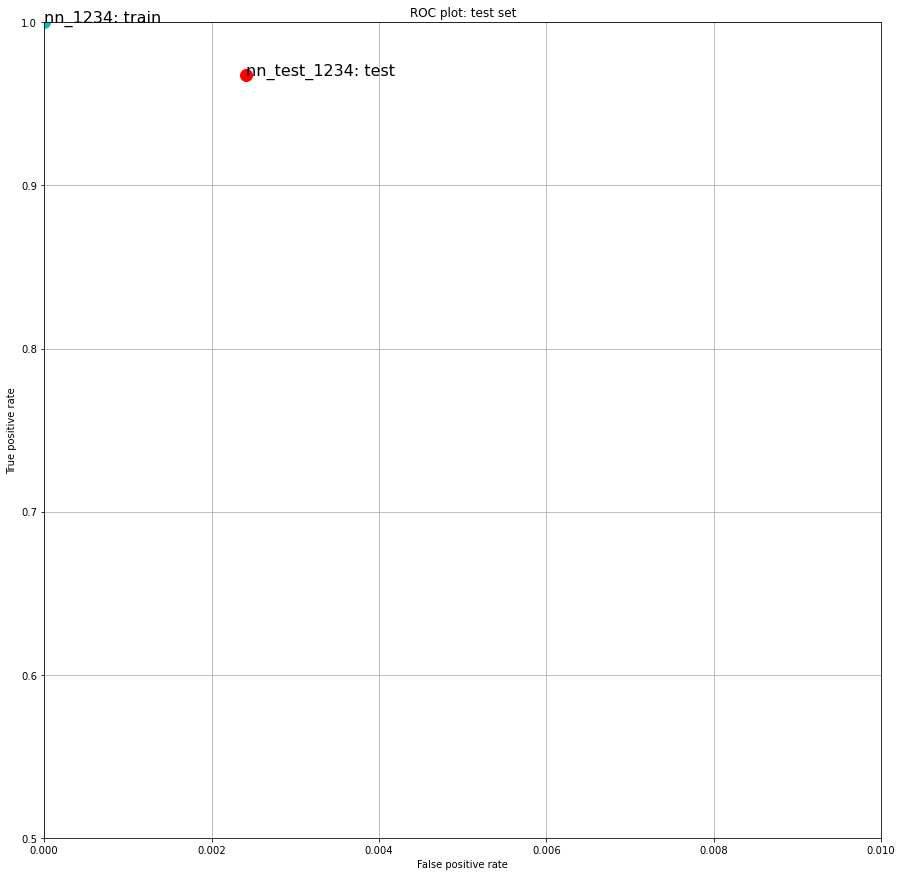

In [12]:
# plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 0.01, 0.5, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.grid(b=True)
plt.show()


# SUBMISSION

### file paths and names:

In [13]:
submission_ci_path = 'test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=72, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 60, 140)
Shape of flat feature representation: 
(1523, 8400)
Shape of X_test for submission:
(1523, 8400)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


### IMPORTANT CHECK: make sure that the number of columns in your training data is the same as the number of columns in this test submission!

In [15]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 8400)
(1523, 8400)


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Both the training set and submission test set have 525 columns. Success!

---

Choose a *single* model for your submission. In this code, I am choosing the Perceptron model fit, which is in the prc object. But you should choose the model that is performing the best for you!

In [16]:
# concatenate predictions to the id
X_test_submission["prediction"] = nn.predict(X_test_data)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.014445173998686802


This is the proportion of predictions that have predicted that there is an airplane in the image.

In [17]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('airplane_submission.csv', index=False)

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
